In [163]:
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import pytorch_ssim
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed

In [164]:
from gym_minigrid.envs.multiroom import MultiRoomEnv

In [165]:
mode = 'multiroom'
minigrid_config = {'size': [200, 200], 'reset_episodes': 3}
env_id=None
set_seed(333)

using seed 333


In [166]:
env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

In [167]:
obs = env.reset()

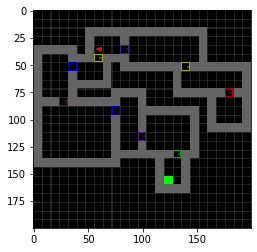

In [168]:
plt.imshow(obs)

In [169]:
env.unwrapped.agent_pos = np.array([22, 8])

In [171]:
env.place_agent(env.env.env.rooms[4].top, env.env.env.rooms[4].size)

array([5, 7])

In [172]:
resized = resize(obs, [25, 25], anti_aliasing=True)

In [180]:
def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    
    side_size = sr_matrix.shape[0]
    
    grid = np.zeros((side_size, side_size))
    for y in range(side_size):
        for x in range(side_size):
            grid[y, x] = np.linalg.norm(sr_matrix[y, x] - starting_sr, 2)
    return grid


def visualize_dsr(sr_source, starting_pos=(1, 8), direction=-1, action=-1, normalize=True):
    if isinstance(sr_source, str):
        if 'pt' in sr_source:
            sr = torch.load(sr_source)
            sr = sr.detach().numpy()
        else:
            sr = np.load(sr_source)
    else:
        sr = sr_source

    if direction == -1:
        sr_matrix = sr.mean(axis=2)
        
    else:
        sr_matrix = sr[:, :, direction]

    if action == -1:
        sr_matrix = sr_matrix.mean(axis=2)
    else:
        sr_matrix = sr_matrix[:, :, action]
    
    side_size = sr_matrix.shape[0]
    
    if normalize:
        sr_matrix = sr_matrix.reshape(side_size ** 2, -1)
        sr_matrix = (sr_matrix - np.nanmean(sr_matrix, axis=0)) / np.nanstd(sr_matrix, axis=0)
        sr_matrix = sr_matrix.reshape(side_size, side_size, -1)
#         sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(side_size, side_size, -1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid


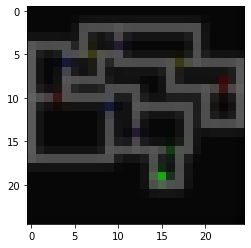

In [173]:
plt.imshow(resized)

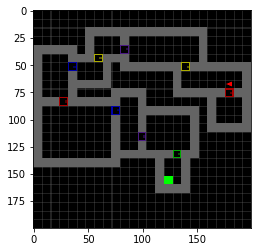

In [170]:
obs = env.step(4)[0]
plt.imshow(obs)

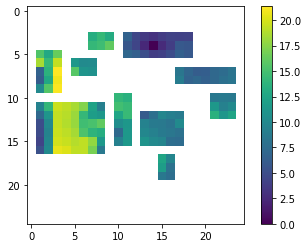

In [213]:
dsr, dsr_heatmap = visualize_dsr('../experiments/successor-data/20200406-run1-500k.pt', (4, 14), -1, -1, True)
plt.imshow(dsr_heatmap)
plt.colorbar()